<a href="https://colab.research.google.com/github/nicslevelcode/nicslevelAI/blob/master/HDB_Resale_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This project aims to explore machine learning using HDB prices from Jan 2017 to Mar 2020
<br> Dataset extracted from: https://data.gov.sg/dataset/resale-flat-prices
<br> Licence: Singapore Open Data Licence

![alt text](https://www.onlinecitizenasia.com/wp-content/uploads/2018/09/featured-image-public-housing-750x375.png)

# Summary

## Conclusion
Considering the nature of trying to predict HDB resale prices, its not a very liquid moving asset that requires real time predictions but rather prefers accuracy and some degree of interpretability. 


* You want accuracy to know that you're obtaining the fair value for your house
* You want some degree of interpretability to understand what factors affect your resale price to be better suited for future transactions (found to be floor area, which town it belongs to and number of years of lease remaining)
* Computationally, whatever this model offers in terms of speed of predictions already beats what exists in the current marketplace

Currently the best model across all the models tested is XGBoosting with a R2 of 0.96932 with the closest training scores to validation scores.
*   More features is not always better, eventually the best scoring model used only 8 from the initial 11 deduced from AutoML
* Everytime we try to make a better prediction (overfit), we end up with 1 or 2 outlier results that pop up. An indication of non-linearity, perhaps that we have not taken into account all available features and we should explore these outliers to find out more
*   Ensemble methods is still one of the best ways to model performance despite a fairly linear and simple problem at hand

The best model may be indeed to consider some form of fine tuned Voting/Stacking.

## Future Improvements

* Investigating outliers
* Adding more easily obtainable features and see how well the model performs (e.g distance from nearest shopping malls, mrt, schools, attractions)
* More data gathering (e.g how much renovation work required for resale, condition of the flat) 
* If we lengthen the data sample size (i.e increase number of years), we may include time series analysis
* Deep Learning to further optimze modelling



# Basic Imports

In [0]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
pd.set_option('display.max_columns', None)

import numpy as np
from datetime import date
from scipy import stats
from scipy.stats import norm, skew
from scipy.stats import boxcox

import matplotlib.pyplot as plt
plt.style.use('dark_background')
%matplotlib inline

import seaborn as sns
sns.set(style="darkgrid")

import io
import requests
import zipfile
import pickle

Loading the dataset into pandas

In [0]:
url = 'https://data.gov.sg/dataset/7a339d20-3c57-4b11-a695-9348adfd7614/download'
headers = {
    'User-Agent': 'Mozilla/5.0',
}
response = requests.get(url, headers=headers)
z = zipfile.ZipFile(io.BytesIO(response.content))
z.extractall()

In [0]:
z.printdir()

File Name                                             Modified             Size
metadata-resale-flat-prices.txt                2020-05-26 16:24:52        13208
resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv 2020-05-26 16:24:52      6908241
resale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016.csv 2020-05-26 16:24:52      3108078
resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv 2020-05-26 16:24:52      4212975
resale-flat-prices-based-on-approval-date-2000-feb-2012.csv 2020-05-26 16:24:54     29739597
resale-flat-prices-based-on-approval-date-1990-1999.csv 2020-05-26 16:24:54     22923132


In [0]:
train=pd.read_csv('resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv')

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70103 entries, 0 to 70102
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   month                70103 non-null  object 
 1   town                 70103 non-null  object 
 2   flat_type            70103 non-null  object 
 3   block                70103 non-null  object 
 4   street_name          70103 non-null  object 
 5   storey_range         70103 non-null  object 
 6   floor_area_sqm       70103 non-null  float64
 7   flat_model           70103 non-null  object 
 8   lease_commence_date  70103 non-null  int64  
 9   remaining_lease      70103 non-null  object 
 10  resale_price         70103 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 5.9+ MB


In [0]:
train.describe()

,floor_area_sqm,lease_commence_date,resale_price
count,70103.000,70103.000,70103.000
mean,97.714,1993.795,438399.819
std,24.244,12.585,153319.471
min,31.000,1966.000,140000.000
25%,82.000,1984.000,328888.000
50%,95.000,1993.000,407000.000
75%,112.000,2003.000,510000.000
max,249.000,2016.000,1232000.000


# Output Variable

We want to explore if our output variable is normally distributed or not and how it would affect the performance of our models

count     70103.000
mean     438399.819
std      153319.471
min      140000.000
25%      328888.000
50%      407000.000
75%      510000.000
max     1232000.000
Name: resale_price, dtype: float64
Skewness: 1.138467
Kurtosis: 1.291612


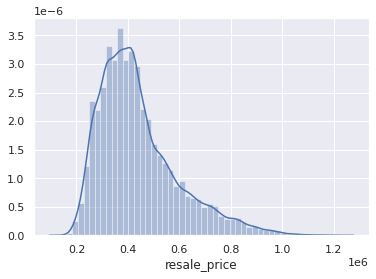

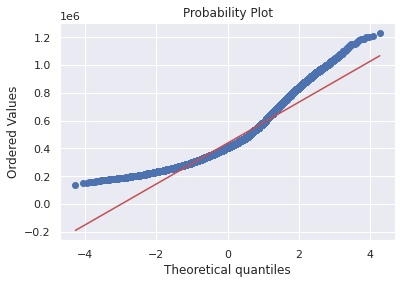

In [0]:
output_var_name = 'resale_price'
output_var = train[output_var_name]
print(output_var.describe())
sns.distplot(output_var)
print("Skewness: %f" % output_var.skew())
print("Kurtosis: %f" % output_var.kurt())
fig = plt.figure()
res = stats.probplot(train[output_var_name], plot=plt)
plt.show()

Trying a log transformer


 mu = 12.94 and sigma = 0.33



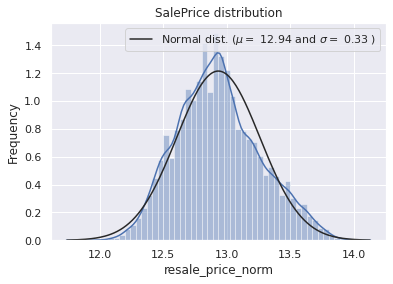

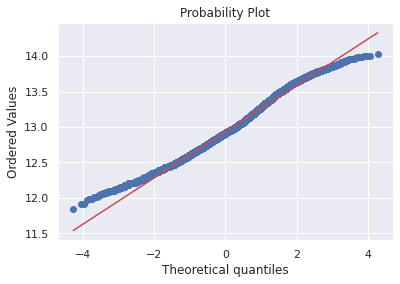

In [0]:
output_var_name_norm = 'resale_price_norm'
train[output_var_name_norm] = np.log1p(train[output_var_name])
sns.distplot(train[output_var_name_norm] , fit=norm);

(mu, sigma) = norm.fit(train[output_var_name_norm])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train[output_var_name_norm], plot=plt)
plt.show()

Trying a Box-Cox Transformer


 mu = 2.85 and sigma = 0.00



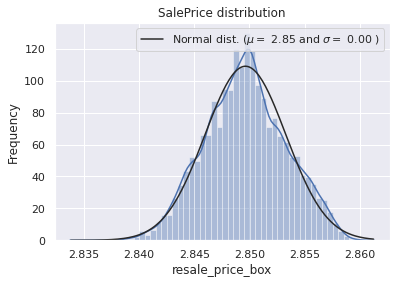

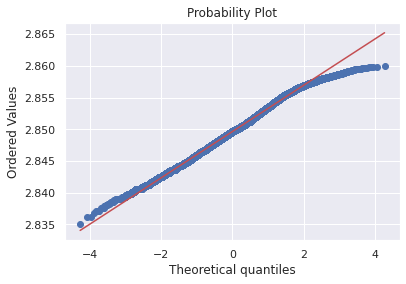

In [0]:
output_var_name_box = 'resale_price_box'
train[output_var_name_box] = stats.boxcox(train[output_var_name])[0]
sns.distplot(train[output_var_name_box] , fit=norm);

(mu, sigma) = norm.fit(train[output_var_name_box])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train[output_var_name_box], plot=plt)
plt.show()

# EDA

In [0]:
print(train.head())
print(train.describe())
print(train.info())

     month        town flat_type block        street_name storey_range  \
0  2017-01  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1  2017-01  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2  2017-01  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3  2017-01  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4  2017-01  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   

   floor_area_sqm      flat_model  lease_commence_date     remaining_lease  \
0          44.000        Improved                 1979  61 years 04 months   
1          67.000  New Generation                 1978  60 years 07 months   
2          67.000  New Generation                 1980  62 years 05 months   
3          68.000  New Generation                 1980   62 years 01 month   
4          67.000  New Generation                 1980  62 years 05 months   

   resale_price  resale_price_box  resale_price_norm  
0    232000.000             2.8

Missing Data - none

In [0]:
train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :train_na})
missing_data.head(20)

,Missing Ratio


## Numerical Exploration

In [0]:
# Extracting year and month
train['year'] = pd.DatetimeIndex(train['month']).year
train['month'] = pd.DatetimeIndex(train['month']).month

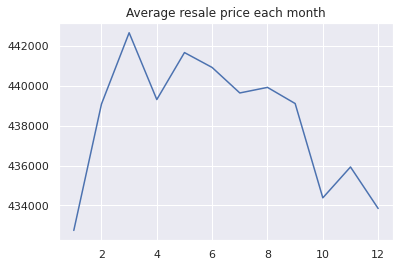

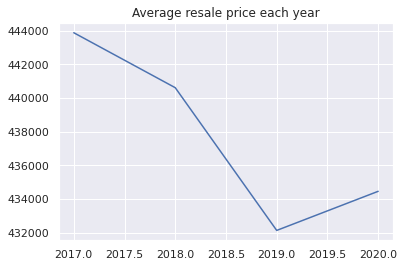

In [0]:
monthly_sales = train.groupby('month').agg({'resale_price':'mean'})
plt.plot(monthly_sales)
plt.title('Average resale price each month')
plt.show()

yearly_sales = train.groupby('year').agg({'resale_price':'mean'})
plt.plot(yearly_sales)
plt.title('Average resale price each year')
plt.show()

Very slight difference in prices based on time periods ~2.5% (10,000 / 400,000)
<br> There appears to be some slight monthly seasonal trends 
<br> Possible to drop these features

                     month  floor_area_sqm  lease_commence_date  resale_price  \
resale_price        -0.007           0.632                0.323         1.000   
floor_area_sqm       0.004           1.000                0.202         0.632   
lease_commence_date  0.007           0.202                1.000         0.323   
month                1.000           0.004                0.007        -0.007   
year                -0.214          -0.016                0.073        -0.029   

                      year  
resale_price        -0.029  
floor_area_sqm      -0.016  
lease_commence_date  0.073  
month               -0.214  
year                 1.000  


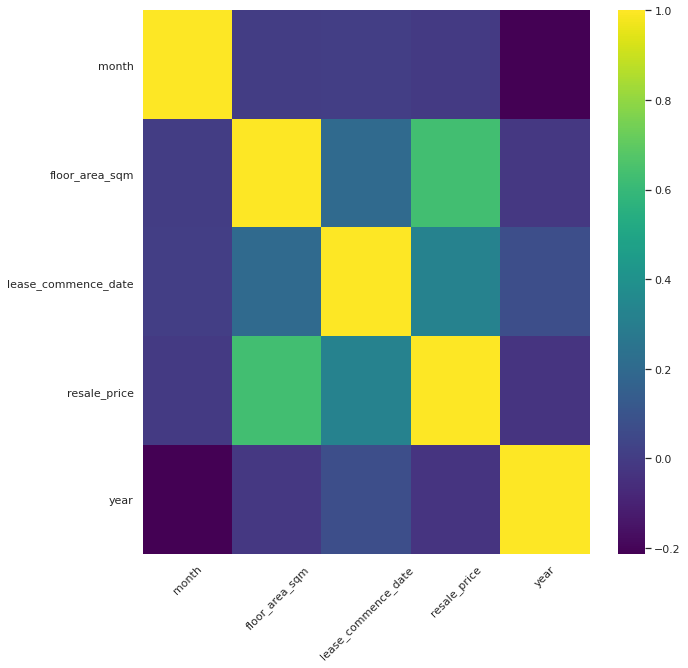

In [0]:
train_eda = train.drop(['resale_price_norm','resale_price_box'],axis=1)
corr = train_eda.corr()
corr.sort_values([output_var_name], ascending = False, inplace = True)
print(corr)

ax = plt.subplots(ncols=1, figsize=(10,10))
corr_matrix = train_eda.corr()
sns.heatmap(corr_matrix,cmap='viridis')
plt.xticks(rotation=45)
plt.show()

No surprise when resale price is most correlated to floor area but less for lease commence date. The minimum for lease commence date is 1966 and most HDBs have 99 year lease which means in the worst case scenario owners can purchase a house for the remaining 45 years (slightly < half of its useful life)

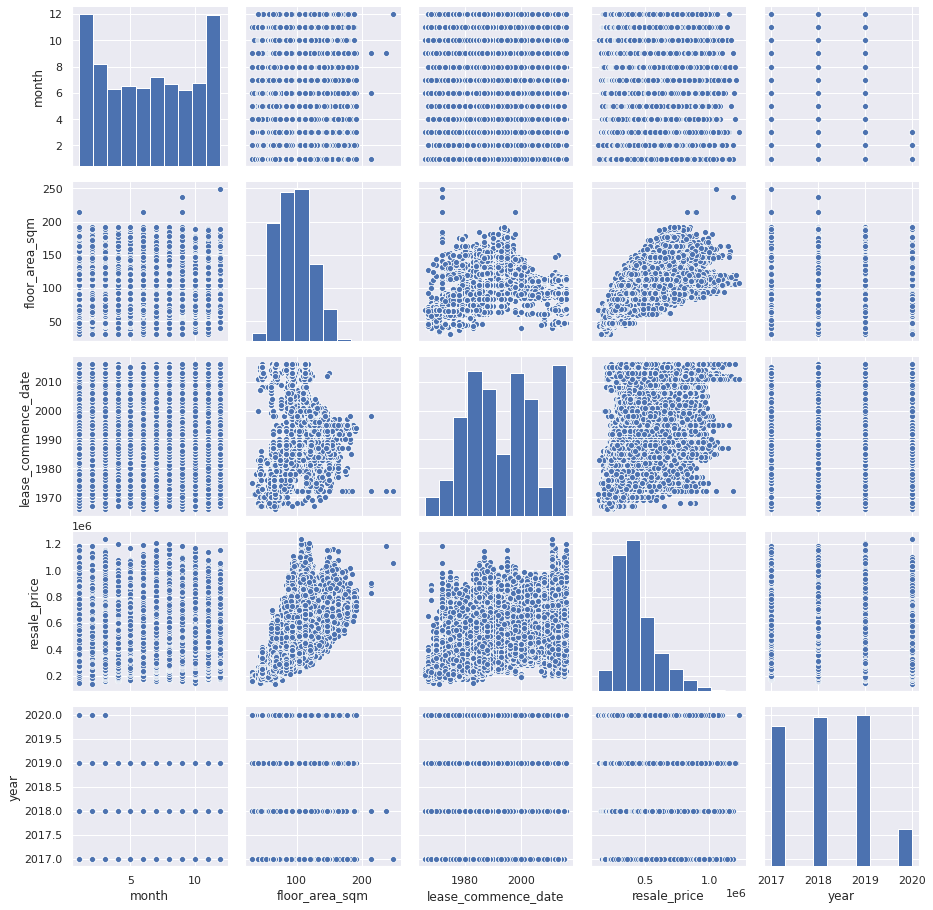

In [0]:
sns.set()
sns.pairplot(train_eda, height = 2.5)
plt.show()

No significant outliers noted

## Categorical Exploration

In [0]:
train_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70103 entries, 0 to 70102
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   month                70103 non-null  int64  
 1   town                 70103 non-null  object 
 2   flat_type            70103 non-null  object 
 3   block                70103 non-null  object 
 4   street_name          70103 non-null  object 
 5   storey_range         70103 non-null  object 
 6   floor_area_sqm       70103 non-null  float64
 7   flat_model           70103 non-null  object 
 8   lease_commence_date  70103 non-null  int64  
 9   remaining_lease      70103 non-null  object 
 10  resale_price         70103 non-null  float64
 11  year                 70103 non-null  int64  
dtypes: float64(2), int64(3), object(7)
memory usage: 6.4+ MB


In [0]:
df_not_num = train_eda[['month','town','flat_type','storey_range','flat_model','lease_commence_date','year']]
# we will not need to visualize remaining leases, block and street_name

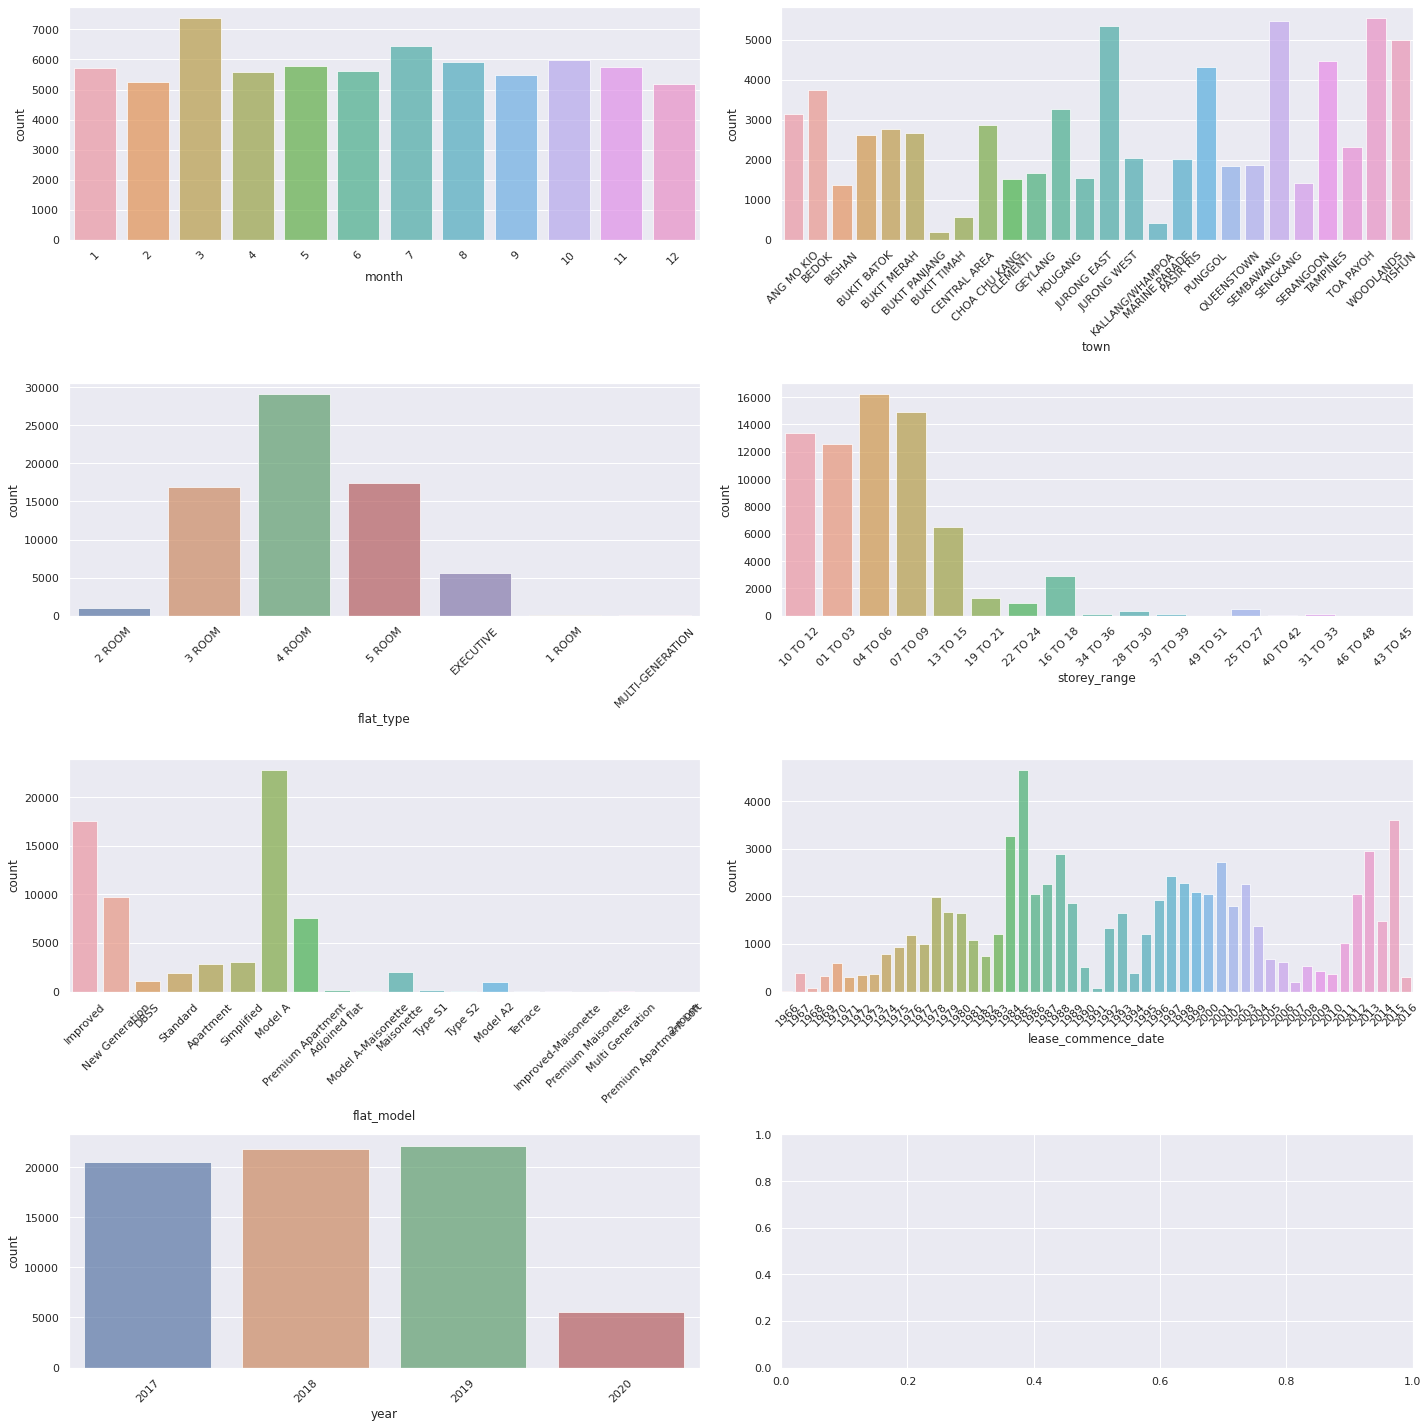

In [0]:
fig, axes = plt.subplots(round(len(df_not_num.columns) / 2), 2, figsize=(20, 20))

for i, ax in enumerate(fig.axes):
    if i < len(df_not_num.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=df_not_num.columns[i], alpha=0.7, data=df_not_num, ax=ax)

fig.tight_layout()

March seems to have significantly more sales possibly accounting for the highest sale prices we saw earlier but only because we cutoff at 2020 data which then suggests Jan and Feb are low sales months

Lets try to find more relationships by using the predictive power score
<br> You can read more here: https://towardsdatascience.com/rip-correlation-introducing-the-predictive-power-score-3d90808b9598

In [0]:
pip install ppscore

  Created wheel for ppscore: filename=ppscore-0.0.2-py2.py3-none-any.whl size=9629 sha256=b1d8a047ba516f3c6876d0ad40639cba636598fe54f990f1e0d487a0beec525b
  Stored in directory: /root/.cache/pip/wheels/29/32/a2/82782fc09f5cd68e401ff047201d38af8965fb94984db18aa5
Successfully built ppscore


In [0]:
import ppscore as pps

This cell takes awhile to run so lets separate it

In [0]:
pps_train_eda = pps.matrix(train_eda);

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 

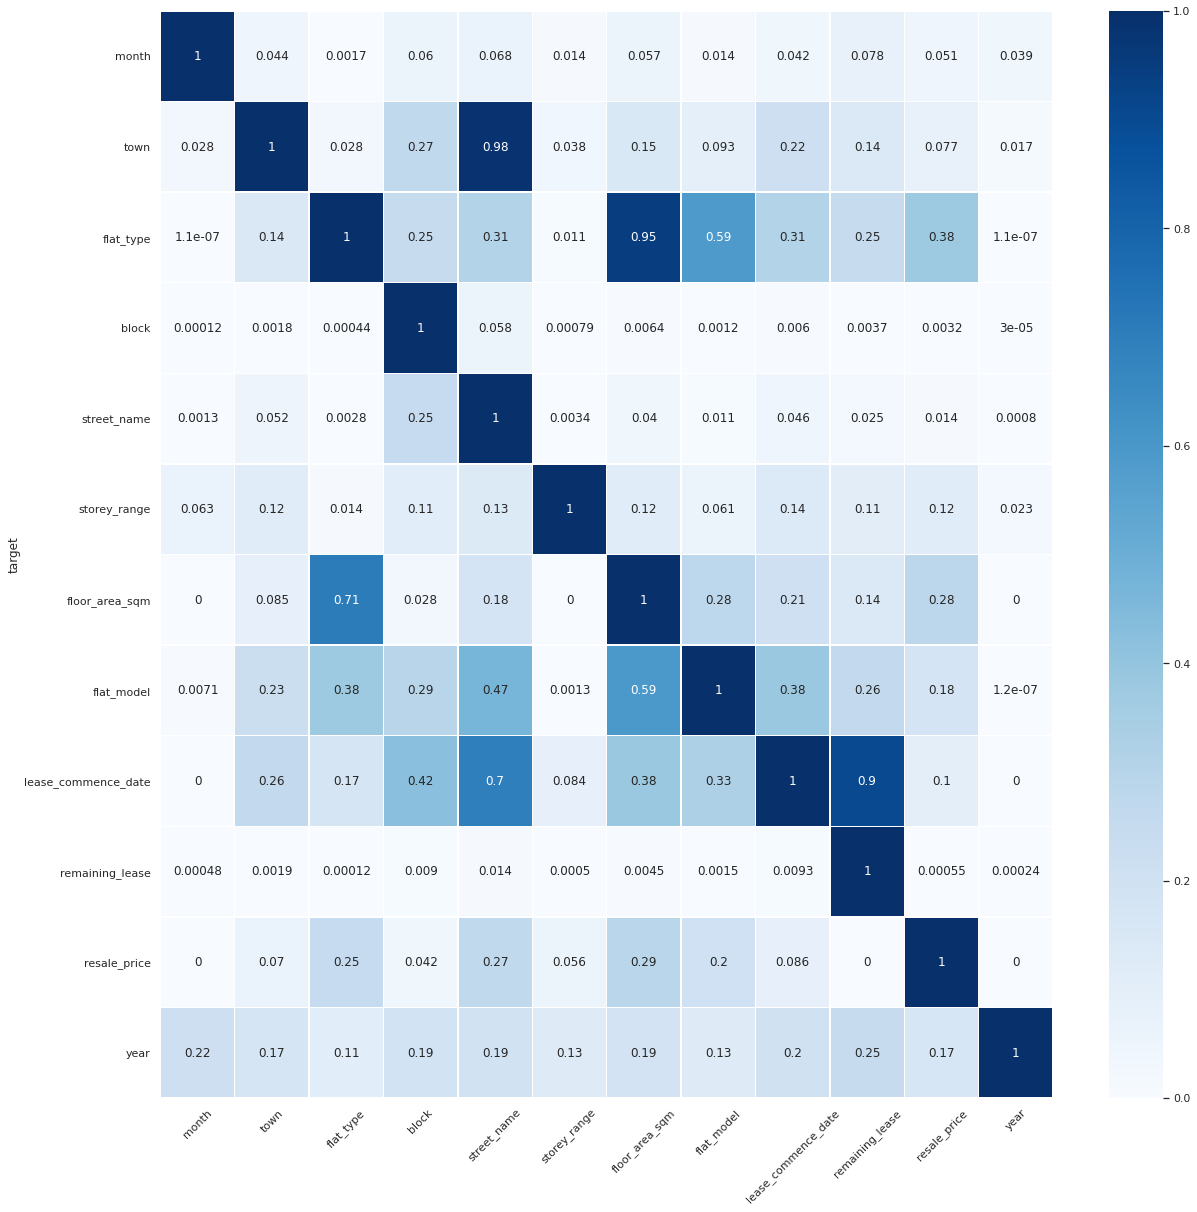

In [0]:
ax = plt.subplots(ncols=1, figsize=(20,20))
sns.heatmap(pps_train_eda, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True);
plt.ylabel('target')
plt.xticks(rotation=45)
plt.show()

Some notable results include flat type, street name (but not town) and flat model
<br> Surprisingly store range doesn't seem to matter much
<br> This map also suggests flat type and floor area seem to be very correlated so we may choose to exclude flat type in our feature selection

# Modelling

In [0]:
# Preprocessing
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler,OneHotEncoder
# Training and tuning
from sklearn.model_selection import train_test_split, cross_val_score
# Algorithms
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, r2_score

## Baseline Simple Linear Regression
R2 of 0.91

Let's see if we can simply model HDB prices based on the most obvious features with as little bells and whistles as possible

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70103 entries, 0 to 70102
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   month                70103 non-null  int64  
 1   town                 70103 non-null  object 
 2   flat_type            70103 non-null  object 
 3   block                70103 non-null  object 
 4   street_name          70103 non-null  object 
 5   storey_range         70103 non-null  object 
 6   floor_area_sqm       70103 non-null  float64
 7   flat_model           70103 non-null  object 
 8   lease_commence_date  70103 non-null  int64  
 9   remaining_lease      70103 non-null  object 
 10  resale_price         70103 non-null  float64
 11  resale_price_norm    70103 non-null  float64
 12  resale_price_box     70103 non-null  float64
 13  year                 70103 non-null  int64  
dtypes: float64(4), int64(3), object(7)
memory usage: 7.5+ MB


In [0]:
features = ['floor_area_sqm','flat_model','lease_commence_date','street_name',]
model_base = train[features]

In [0]:
numerical_features = model_base.select_dtypes(include=['int64','float64']).columns
categorical_features = model_base.select_dtypes(include=['object']).columns

preprocess = make_column_transformer(
       (make_pipeline(MinMaxScaler()), numerical_features),
       (make_pipeline(OneHotEncoder()), categorical_features))

training_set_base = preprocess.fit_transform(model_base)

In [0]:
output_var = train[output_var_name]
X_train, X_test, y_train, y_test = train_test_split(
    training_set_base,
    output_var,
    test_size=0.2,
    random_state=642,
    shuffle=True
    )

In [0]:
LR=LinearRegression()
LR.fit(X_train,y_train)
y_pred=LR.predict(X_test)

In [0]:
len(y_train)

56082

In [0]:
X_train.shape

(56082, 565)

In [0]:
r2 = r2_score(y_test,y_pred)
print("R2 Score: {:.5f}".format(r2))
print("Adj R2 Score: {:.2f}".format(1 - (1-r2)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: {:.2f}".format(rmse))

R2 Score: 0.91504
Adj R2 Score: 0.91
RMSE: 45001.67


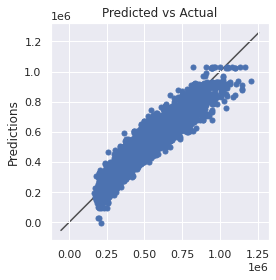

In [0]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, s=25, cmap=plt.cm.coolwarm)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')

plt.ylabel('Predictions')
plt.title('Predicted vs Actual')
plt.show()

Results look promising with a R squared of 0.915 and Adj R squared of 0.91 considering our initial resale price data is actually skewed.
<br>
<br> The model tends to predict lower prices for higher priced flats/lower priced flats. We already expected this from the probplot of the resale price. So perhaps this model might work better for you if you're looking to buy the 3-5 room flats which is the majority in the dataset.
<br>
<br> However we should also consider that we have observed an obvious linear relationship when looking at floor area vs resale price hence this is promising but expected.

## Adding more Features
0.94397 after adding all the features

What is the limit to how many features we can add? Let's add all the features and see what happens. We can still afford this since this is computationally cheap.

In [0]:
train.month = train.month.astype('category')
train.year = train.year.astype('category')

In [0]:
features = ['floor_area_sqm','flat_model','lease_commence_date','street_name','flat_type','storey_range','town','month','year','block','remaining_lease']
model_moref = train[features]

In [0]:
numerical_features = model_moref.select_dtypes(include=['int64','float64']).columns
categorical_features = model_moref.select_dtypes(include=['object','category']).columns

preprocess = make_column_transformer(
       (make_pipeline(MinMaxScaler()), numerical_features),
       (make_pipeline(OneHotEncoder()), categorical_features))

training_set_moref = preprocess.fit_transform(model_moref)

In [0]:
output_var = train[output_var_name]
X_train, X_test, y_train, y_test = train_test_split(
    training_set_moref,
    output_var,
    test_size=0.2,
    random_state=642,
    shuffle=True
    )

In [0]:
LR.fit(X_train,y_train)
y_pred=LR.predict(X_test)

In [0]:
len(y_train)

56082

In [0]:
X_train.shape

(56082, 3656)

In [0]:
r2 = r2_score(y_test,y_pred)
print("R2 Score: {:.5f}".format(r2))
print("Adj R2 Score: {:.2f}".format(1 - (1-r2)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: {:.2f}".format(rmse))

R2 Score: 0.94397
Adj R2 Score: 0.94
RMSE: 36544.88


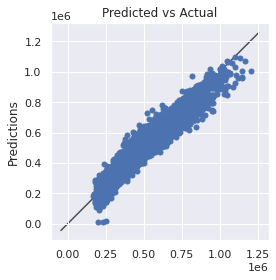

In [0]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, s=25, cmap=plt.cm.coolwarm)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')

plt.ylabel('Predictions')
plt.title('Predicted vs Actual')
plt.show()

The numerical results actually got slightly better. Overall the thickness of the mass of results has also decreased indicated an overall better mode with a tighter fit.
<br> 
<br> However if you notice the graph, there is actually one more 'wild' prediction made by the model as there are a few dots deviating significantly away from the main line drawn in the center near the bottom. This is noise at work.
<br> 
<br> In spite of that the results got better overall. The model already had tons of data for training on 3-5 room flats. Perhaps the rarer, pricier flat types, block numbers or accounting for seasonal data got more data to train on to slightly improve the model performance.
<br>
<br> There are probably very few outliers in the initial dataset thus the model doesnt really have a lot of noise to affect its overall performance but we can clearly see the effect of adding more features (both signal and noise). A very important reminder on visualizing your data instead of relying purely on numerical results.

## Validation

In [0]:
cv_5_results = cross_val_score(LR, training_set_base, output_var, cv=5, scoring='neg_root_mean_squared_error')

In [0]:
cv_5_results

array([-46423.97451766, -45529.65586862, -45379.64031113, -46677.90727665,
       -46877.82889021])

Validation error low and slightly higher than the training error. This suggests a pretty good fit so far for the original linear regression


In [0]:
cv_5_results = cross_val_score(LR, training_set_moref, output_var, cv=5, scoring='neg_root_mean_squared_error')

In [0]:
cv_5_results

[-38088.99801441 -37652.11849365 -37372.02128575 -37811.4603114
 -41159.07736887]


The absolute RMSE error amount is slightly higher vs the training set for the linear regression with all the features suggesting we're moving into overfitted territory

## Improving the Model

### Normalization
Using normalization on the resale price we achieved R2 0.95452 but the validation results are worse

Let's try to normalize the data and see if we fare better

In [0]:
features = ['floor_area_sqm','flat_model','lease_commence_date','street_name','flat_type','storey_range','town','month','year','block','remaining_lease']
model_norm = train[features]

In [0]:
numerical_features = model_norm.select_dtypes(include=['int64','float64']).columns
categorical_features = model_norm.select_dtypes(include=['object','category']).columns

preprocess = make_column_transformer(
       (make_pipeline(StandardScaler()), numerical_features),
       (make_pipeline(OneHotEncoder()), categorical_features))

training_set_norm = preprocess.fit_transform(model_norm)

In [0]:
output_var = train[output_var_name_norm]
X_train, X_test, y_train, y_test = train_test_split(
    training_set_norm,
    train[output_var_name_norm],
    test_size=0.2,
    random_state=642,
    shuffle=True
    )

In [0]:
LR.fit(X_train,y_train)
y_pred=LR.predict(X_test)

In [0]:
r2 = r2_score(y_test,y_pred)
print("R2 Score: {:.5f}".format(r2))
print("Adj R2 Score: {:.5f}".format(1 - (1-r2)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: {:.5f}".format(rmse))

R2 Score: 0.95452
Adj R2 Score: 0.95135
RMSE: 0.07039


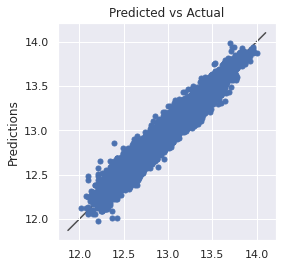

In [0]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, s=25, cmap=plt.cm.coolwarm)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')

plt.ylabel('Predictions')
plt.title('Predicted vs Actual')
plt.show()

In [0]:
cv_5_results = cross_val_score(LR, training_set_norm, train[output_var_name_norm], cv=5, scoring='neg_root_mean_squared_error')

In [0]:
cv_5_results

array([-0.07625778, -0.0713303 , -0.0717455 , -0.07372459, -0.08107541])

In [0]:
output_var = train[output_var_name_box]
X_train, X_test, y_train, y_test = train_test_split(
    training_set_norm,
    train[output_var_name_box],
    test_size=0.2,
    random_state=642,
    shuffle=True
    )

In [0]:
LR.fit(X_train,y_train)
y_pred=LR.predict(X_test)

In [0]:
r2 = r2_score(y_test,y_pred)
print("R2 Score: {:.5f}".format(r2))
print("Adj R2 Score: {:.5f}".format(1 - (1-r2)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: {:.5f}".format(rmse))

R2 Score: 0.95176
Adj R2 Score: 0.94839
RMSE: 0.00081


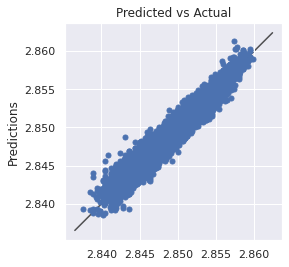

In [0]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, s=25, cmap=plt.cm.coolwarm)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')

plt.ylabel('Predictions')
plt.title('Predicted vs Actual')
plt.show()

In [0]:
cv_5_results = cross_val_score(LR, training_set_norm, train[output_var_name_box], cv=5, scoring='neg_root_mean_squared_error')

In [0]:
cv_5_results

array([-0.00087492, -0.00081058, -0.00082111, -0.00085072, -0.00093291])

A very obvious tighter fit at both the higher and lower priced flats when normalizing but also more predictions straying away from the main group. This is expected since the prob plot for normalization shows significant improvement. Let's continue working with the initial normalization.

### Regularization
Using Ridge Regression and Normalization of resale price we achieved R2 of 0.95370

In [0]:
from sklearn.linear_model import Ridge, Lasso

In [0]:
output_var = train[output_var_name_norm]
X_train, X_test, y_train, y_test = train_test_split(
    training_set_norm,
    train[output_var_name],
    test_size=0.2,
    random_state=642,
    shuffle=True
    )

In [0]:
lasso = Lasso(alpha=0.0001)
lasso.fit(X_train,y_train)
y_pred=lasso.predict(X_test)

In [0]:
r2 = r2_score(y_test,y_pred)
print("R2 Score: {:.5f}".format(r2))
print("Adj R2 Score: {:.5f}".format(1 - (1-r2)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: {:.5f}".format(rmse))

In [0]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, s=25, cmap=plt.cm.coolwarm)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')

plt.ylabel('Predictions')
plt.title('Predicted vs Actual')
plt.show()

In [0]:
cv_5_results = cross_val_score(LR, training_set_norm, train[output_var_name], cv=5, scoring='neg_root_mean_squared_error')

In [0]:
cv_5_results

In [0]:
output_var = train[output_var_name_norm]
X_train, X_test, y_train, y_test = train_test_split(
    training_set_norm,
    train[output_var_name_norm],
    test_size=0.2,
    random_state=642,
    shuffle=True
    )

In [0]:
ridge = Ridge(alpha=0.005)
ridge.fit(X_train,y_train)
y_pred=ridge.predict(X_test)

In [0]:
r2 = r2_score(y_test,y_pred)
print("R2 Score: {:.7f}".format(r2))
print("Adj R2 Score: {:.7f}".format(1 - (1-r2)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: {:.7f}".format(rmse))

R2 Score: 0.9537021
Adj R2 Score: 0.9504733
RMSE: 0.0710219


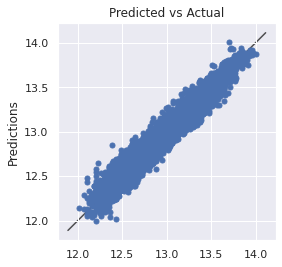

In [0]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, s=25, cmap=plt.cm.coolwarm)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')

plt.ylabel('Predictions')
plt.title('Predicted vs Actual')
plt.show()

In [0]:
cv_5_results = cross_val_score(ridge, training_set_norm, train[output_var_name_norm], cv=5, scoring='neg_root_mean_squared_error')

In [0]:
cv_5_results

array([-0.07702523, -0.07219186, -0.0722709 , -0.07357958, -0.07747766])

The ridge regression helps to reduce the validation errors significantly from normalization.

### Tuning Features
Using less features we achieved 0.95372 on Linear Regression

Is more always better? Let's remove duplicate features and do some feature engineering to try to remove noise instead.


1. Lease commence data and remaining lease are obviously the same but we'll do feature rescaling and approximate the number years remaining
2. Street name and town are kind of similar but street name is more specific



In [0]:
train['lease_months']=train['remaining_lease'].str.extract(r'(\s\d{1,2}\s)')

In [0]:
train.lease_months.replace('(\s[0])','',regex=True,inplace=True)

In [0]:
train.lease_months.replace('(\s)','',regex=True,inplace=True)
train.lease_months.replace('(\s)','',regex=True,inplace=True)

In [0]:
train.lease_months.replace('',0,inplace=True)

In [0]:
train.lease_months.fillna(0,inplace=True)

In [0]:
train.lease_months = train.lease_months.astype(int)

In [0]:
train.lease_months = train.lease_months/12

In [0]:
train['lease_years']=train['remaining_lease'].str.extract(r'(^\d{1,2})')

In [0]:
train.lease_years = train.lease_years.astype(int)

In [0]:
train.lease_years = train.lease_years + train.lease_months

In [0]:
features = ['floor_area_sqm','flat_model','street_name','flat_type','storey_range','lease_years','block','month','year']
model_reeng = train[features]

In [0]:
numerical_features = model_reeng.select_dtypes(include=['int64','float64']).columns
categorical_features = model_reeng.select_dtypes(include=['object','category']).columns

preprocess = make_column_transformer(
       (make_pipeline(StandardScaler()), numerical_features),
       (make_pipeline(OneHotEncoder()), categorical_features))

training_set_reeng = preprocess.fit_transform(model_reeng)

In [0]:
output_var = train[output_var_name_norm]
X_train, X_test, y_train, y_test = train_test_split(
    training_set_reeng,
    train[output_var_name_norm],
    test_size=0.2,
    random_state=642,
    shuffle=True
    )

In [0]:
LR=LinearRegression()
LR.fit(X_train,y_train)
y_pred=LR.predict(X_test)

In [0]:
r2 = r2_score(y_test,y_pred)
print("R2 Score: {:.5f}".format(r2))
print("Adj R2 Score: {:.5f}".format(1 - (1-r2)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: {:.5f}".format(rmse))

R2 Score: 0.95372
Adj R2 Score: 0.95109
RMSE: 0.07101


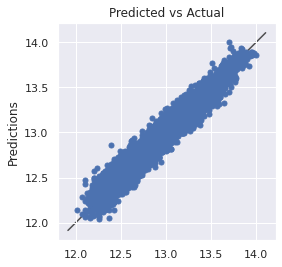

In [0]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, s=25, cmap=plt.cm.coolwarm)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')

plt.ylabel('Predictions')
plt.title('Predicted vs Actual')
plt.show()

In [0]:
cv_5_results = cross_val_score(LR, training_set_reeng, train[output_var_name_norm], cv=5, scoring='neg_root_mean_squared_error')

In [0]:
cv_5_results

array([-0.07765418, -0.0719635 , -0.07083276, -0.07346176, -0.079355  ])

In [0]:
features = ['floor_area_sqm','flat_model','street_name','flat_type','storey_range','lease_years','block','month','year']
model_reeng = train[features]

In [0]:
numerical_features = model_reeng.select_dtypes(include=['int64','float64']).columns
categorical_features = model_reeng.select_dtypes(include=['object','category']).columns

preprocess = make_column_transformer(
       (make_pipeline(StandardScaler()), numerical_features),
       (make_pipeline(OneHotEncoder()), categorical_features))

training_set_reeng = preprocess.fit_transform(model_reeng)

In [0]:
output_var = train[output_var_name_norm]
X_train, X_test, y_train, y_test = train_test_split(
    training_set_reeng,
    train[output_var_name_norm],
    test_size=0.2,
    random_state=642,
    shuffle=True
    )

In [0]:
ridge.fit(X_train,y_train)
y_pred=ridge.predict(X_test)

In [0]:
r2 = r2_score(y_test,y_pred)
print("R2 Score: {:.5f}".format(r2))
print("Adj R2 Score: {:.5f}".format(1 - (1-r2)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: {:.5f}".format(rmse))

R2 Score: 0.95212
Adj R2 Score: 0.94940
RMSE: 0.07223


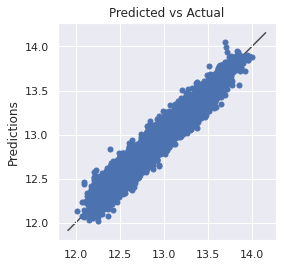

In [0]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, s=25, cmap=plt.cm.coolwarm)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')

plt.ylabel('Predictions')
plt.title('Predicted vs Actual')
plt.show()

In [0]:
cv_5_results = cross_val_score(ridge, training_set_reeng, train[output_var_name_norm], cv=5, scoring='neg_root_mean_squared_error')

In [0]:
cv_5_results

array([-0.07922558, -0.07319526, -0.07201749, -0.07510509, -0.07891162])

### Boosting
0.96711 while using XGBoost

Boosting is a very strong technique to make predictions but we have to make sure to watch out for overfitting by cross validation

In [0]:
import xgboost as xgb

In [0]:
XGBoost = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.15, max_delta_step=0, max_depth=10,
             min_child_weight=3, missing=None, n_estimators=1250, n_jobs=0,
             nthread=None, num_parallel_tree=1, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=0)

In [0]:
features = ['floor_area_sqm','flat_model','street_name','flat_type','storey_range','lease_years','block','year','month']
model_reeng = train[features]

In [0]:
numerical_features = model_reeng.select_dtypes(include=['int64','float64']).columns
categorical_features = model_reeng.select_dtypes(include=['object','category']).columns

preprocess = make_column_transformer(
       (make_pipeline(StandardScaler()), numerical_features),
       (make_pipeline(OneHotEncoder()), categorical_features))

training_set_reeng = preprocess.fit_transform(model_reeng)

In [0]:
output_var = train[output_var_name_norm]
X_train, X_test, y_train, y_test = train_test_split(
    training_set_reeng,
    train[output_var_name_norm],
    test_size=0.2,
    random_state=42,
    shuffle=True
    )

In [0]:
XGBoost.fit(X_train,y_train)
y_pred=XGBoost.predict(X_test)

In [0]:
r2 = r2_score(y_test,y_pred)
print("R2 Score: {:.5f}".format(r2))
print("Adj R2 Score: {:.5f}".format(1 - (1-r2)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: {:.5f}".format(rmse))

R2 Score: 0.96711
Adj R2 Score: 0.96524
RMSE: 0.05913


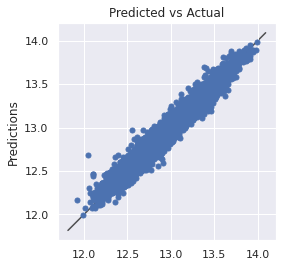

In [0]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, s=25, cmap=plt.cm.coolwarm)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')

plt.ylabel('Predictions')
plt.title('Predicted vs Actual')
plt.show()

In [0]:
n_estimators = [500, 1000, 250, 750, 1250]
max_depth = [2, 3, 5, 7, 10]
booster=['gbtree','gblinear']
learning_rate=[0.05,0.1,0.15,0.2]
min_child_weight=[1,2,3,4]
base_score=[0.25,0.5,0.75,1]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
    }
random_cv = RandomizedSearchCV(estimator=XGBoost,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

random_cv.fit(X_train,y_train)
print(random_cv.best_estimator_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 13.2min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 31.4min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 49.0min finished


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.15, max_delta_step=0, max_depth=10,
             min_child_weight=3, missing=None, n_estimators=1250, n_jobs=0,
             nthread=None, num_parallel_tree=1, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=0)


### AutoML
Instead of manually tuning, can AutoML can help us tune and find a more suitable model more efficiently?
<br> https://docs.microsoft.com/en-us/azure/machine-learning/tutorial-first-experiment-automated-ml

First lets export the data

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70103 entries, 0 to 70102
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   month                70103 non-null  category
 1   town                 70103 non-null  object  
 2   flat_type            70103 non-null  object  
 3   block                70103 non-null  object  
 4   street_name          70103 non-null  object  
 5   storey_range         70103 non-null  object  
 6   floor_area_sqm       70103 non-null  float64 
 7   flat_model           70103 non-null  object  
 8   lease_commence_date  70103 non-null  int64   
 9   remaining_lease      70103 non-null  object  
 10  resale_price         70103 non-null  float64 
 11  resale_price_norm    70103 non-null  float64 
 12  resale_price_box     70103 non-null  float64 
 13  year                 70103 non-null  category
 14  lease_years          70103 non-null  float64 
 15  lease_months       

In [0]:
from google.colab import files

In [0]:
train.to_csv('export.csv') 
files.download('export.csv')

The results of the AutoML with the following features with normalization of the resale price
1. floor_area_sqm
2. flat_model
3. street_name
4. flat_type
5. storey_range
6. lease_years
7. block
8. year
9. month
10. town

AutoML Results

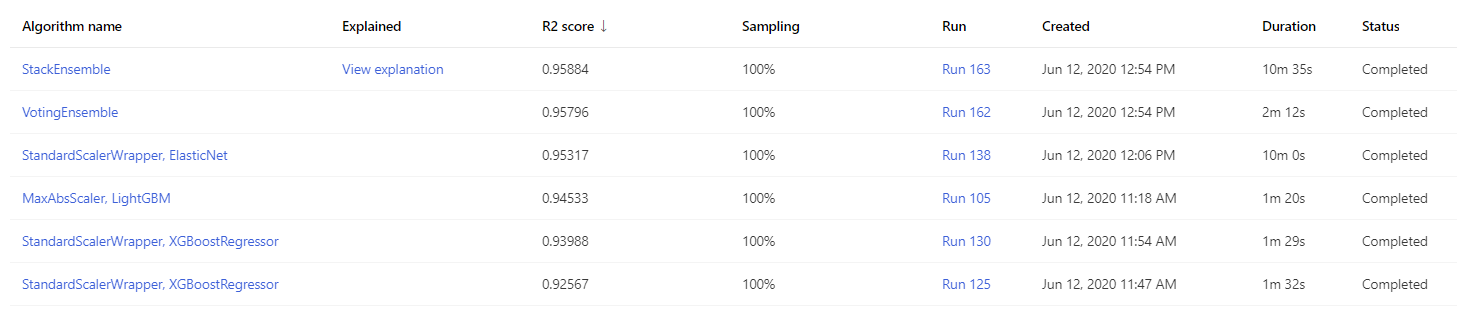

AutoML helps us quickly confirm what we already know anecdotally
* In order to improve model performance we need some form of regularization of the noise (ElasticNet)
* To optimize even further we can utilise a variety of models (Stacking, Voting, Boosting) albeit this reduces interpretability somewhat.

For the Stacking Ensemble

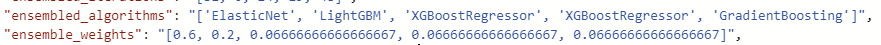

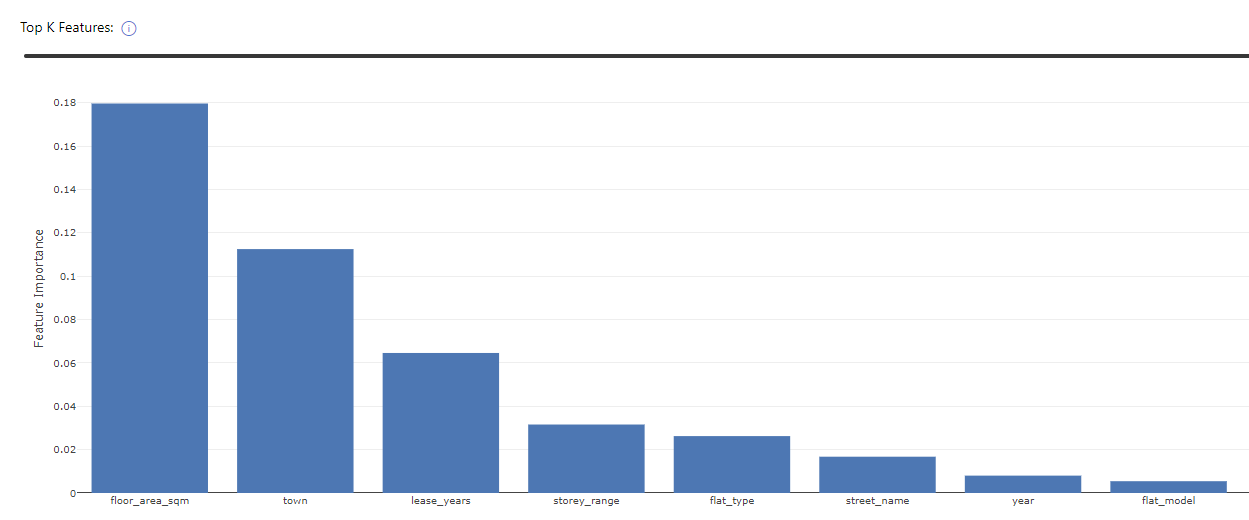

Aren't we glad to have rescaled the lease_years feature, it would have been good to get more breakdown from storey range as well. 
<br> Town feature is also validated here to be important.
<br> Block and month seems to be completely useless

For the Voting Ensemble

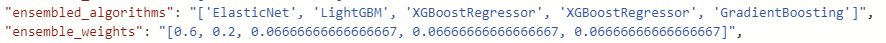

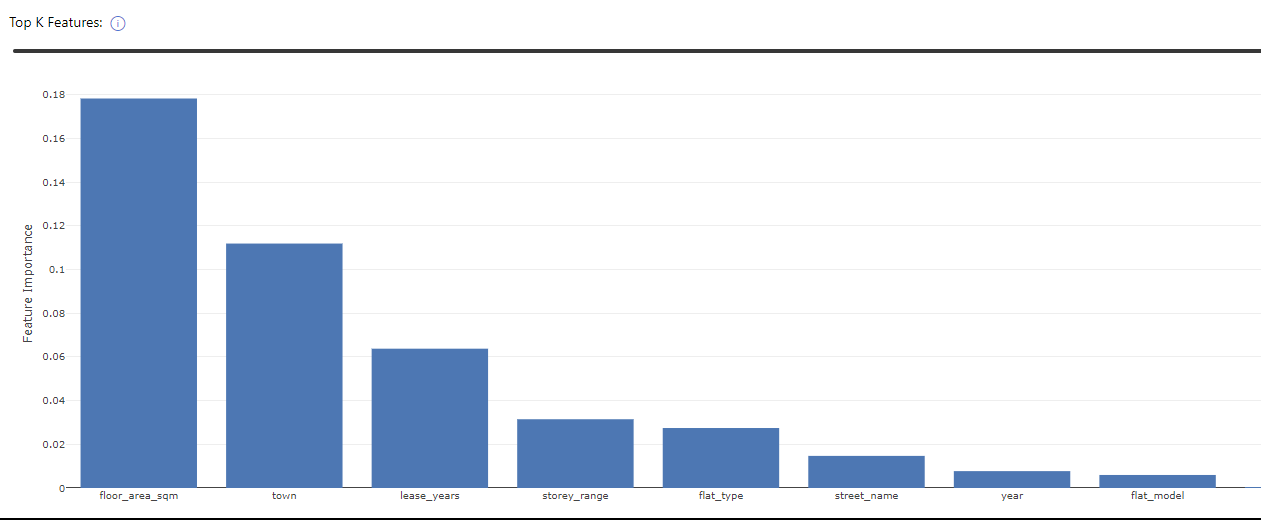

The ElasticNet results have a pretty low alpha with l1 ratio which is consistent with our previous results, its essentially a ridge regression at this point. ElasticNet also holds the largest proportion of the weightage in the stacks/votes. The benefits of brute forcing models and parameters!

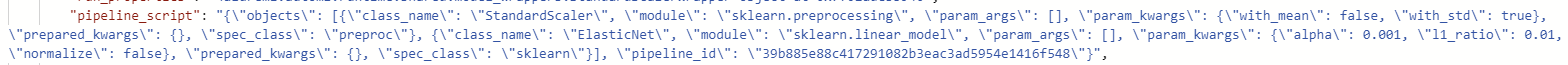

Town seems like an important feature for all models so we'll add it back in

### Attempting to finetune models

#### Ridge
R2 0.94583, actually performed worse than the previous ridge when removing features

In [0]:
features = ['floor_area_sqm','flat_model','lease_years','street_name','flat_type','storey_range','town','year']
model_tuned = train[features]

In [0]:
numerical_features = model_tuned.select_dtypes(include=['int64','float64']).columns
categorical_features = model_tuned.select_dtypes(include=['object','category']).columns

preprocess = make_column_transformer(
       (make_pipeline(MinMaxScaler()), numerical_features),
       (make_pipeline(OneHotEncoder()), categorical_features))

training_set_tuned = preprocess.fit_transform(model_tuned)

In [0]:
output_var = train[output_var_name_norm]
X_train, X_test, y_train, y_test = train_test_split(
    training_set_tuned,
    train[output_var_name_norm],
    test_size=0.2,
    random_state=642,
    shuffle=True
    )

In [0]:
ridge = Ridge(alpha=0.001)
ridge.fit(X_train,y_train)
y_pred=ridge.predict(X_test)

In [0]:
r2 = r2_score(y_test,y_pred)
print("R2 Score: {:.7f}".format(r2))
print("Adj R2 Score: {:.7f}".format(1 - (1-r2)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: {:.7f}".format(rmse))

R2 Score: 0.9458339
Adj R2 Score: 0.9452293
RMSE: 0.0768202


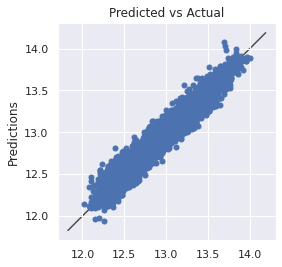

In [0]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, s=25, cmap=plt.cm.coolwarm)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')

plt.ylabel('Predictions')
plt.title('Predicted vs Actual')
plt.show()

In [0]:
cv_5_results = cross_val_score(ridge, training_set_tuned, train[output_var_name_norm], cv=5, scoring='neg_root_mean_squared_error')

In [0]:
cv_5_results

array([-0.0816118 , -0.07730364, -0.0764379 , -0.07892953, -0.08058097])

#### XGBoost
R2 0.96932, slightly better than the previous XGBoost

In [0]:
XGBoost.fit(X_train,y_train)
y_pred=XGBoost.predict(X_test)

In [0]:
r2 = r2_score(y_test,y_pred)
print("R2 Score: {:.5f}".format(r2))
print("Adj R2 Score: {:.5f}".format(1 - (1-r2)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: {:.5f}".format(rmse))

R2 Score: 0.96932
Adj R2 Score: 0.96898
RMSE: 0.05781


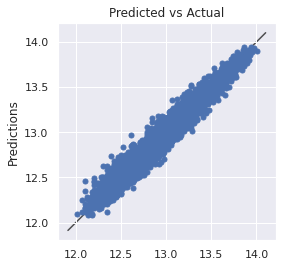

In [0]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, s=25, cmap=plt.cm.coolwarm)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')

plt.ylabel('Predictions')
plt.title('Predicted vs Actual')
plt.show()

In [0]:
cv_5_results = cross_val_score(XGBoost, training_set_tuned, train[output_var_name_norm], cv=5, scoring='neg_root_mean_squared_error')

In [0]:
cv_5_results

array([-0.06261704, -0.06016869, -0.06322079, -0.06039961, -0.06578359])

#### Voting

R2 0.93078

In [0]:
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

In [0]:
reg1 = GradientBoostingRegressor(random_state=1, n_estimators=10)
reg2 = RandomForestRegressor(random_state=1, n_estimators=10)
reg3 = ridge
reg4 = LR
ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('rd', reg3),('lr',reg4)])
ereg = ereg.fit(X_train,y_train)
y_pred=ereg.predict(X_test)

In [0]:
r2 = r2_score(y_test,y_pred)
print("R2 Score: {:.7f}".format(r2))
print("Adj R2 Score: {:.7f}".format(1 - (1-r2)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: {:.7f}".format(rmse))

R2 Score: 0.9307808
Adj R2 Score: 0.9300083
RMSE: 0.0868410


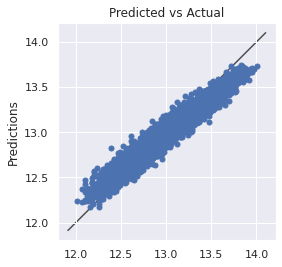

In [0]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, s=25, cmap=plt.cm.coolwarm)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')

plt.ylabel('Predictions')
plt.title('Predicted vs Actual')
plt.show()

In [0]:
cv_5_results = cross_val_score(ereg, training_set_tuned, train[output_var_name_norm], cv=5, scoring='neg_root_mean_squared_error')

In [0]:
cv_5_results

array([-0.079119  , -0.08375801, -0.09139505, -0.09395248, -0.09419193])